<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_GAN/blob/master/CGAN_no_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow==2.1
# https://medium.com/@mafda_/gans-conditional-gans-with-mnist-part-4-7f816d274d8c

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Lambda, ReLU, Input, concatenate, InputLayer, Flatten, Conv2D, Dense, BatchNormalization, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential, optimizers, metrics

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

In [ ]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

(60000, 28, 28)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
batch_size = 256
noise_dim = 100
lr = 1e-4

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
type(train_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
class CGAN(keras.Model):

  def __init__(self, **kwargs):
    super(CGAN, self).__init__()
    self.__dict__.update(kwargs)

    self.generator = Sequential(self.gen_nn)    
    self.discriminator = Sequential(self.dis_nn)
    self.cross_entropy = self.cross_entropy
    self.noise_z = self.noise

  def Generator(self, x, condition, training):
    input = concatenate([x, condition])
    if training == True:
      gen = self.generator(input, training=True)
    else:
      gen = self.generator(input, training=False)
    return gen 

  def Discriminator(self, x, condition):
    # condition = Input(shape=(condition.shape[1],))  
    x = tf.reshape(x, [256, 784])
    input = concatenate([x, condition])

    dis = self.discriminator(input, training=True)
    return dis

  @tf.function
  def dis_loss(self, real_output, fake_output):
    real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss 
    return total_loss

  @tf.function 
  def gen_loss(self, fake_output):
    loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

  @tf.function
  def compute_gradient(self, x, condition):
    noise = self.noise_z
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
      generated_img = self.Generator(noise, condition, True)
                  
      real_output = self.Discriminator(x, condition)
      fake_output = self.Discriminator(generated_img, condition)
      
      '''TODO: (256, 1로 만들기)'''
      
      # fake_output = tf.convert_to_tensor(fake_output, dtype=tf.float32)

      loss_gen = self.gen_loss(fake_output)
      loss_dis = self.dis_loss(real_output, fake_output)

    gradient_gen = gen_tape.gradient(loss_gen, self.generator.trainable_variables)
    gradient_dis = dis_tape.gradient(loss_dis, self.discriminator.trainable_variables)

    return gradient_gen, gradient_dis, loss_gen, loss_dis

  @tf.function
  def train(self, x, condition):
    gradient_gen, gradient_dis, loss_gen, loss_dis = self.compute_gradient(x, condition)
    self.gen_optimizer.apply_gradients(zip(gradient_gen, self.generator.trainable_variables))
    self.dis_optimizer.apply_gradients(zip(gradient_dis, self.discriminator.trainable_variables))
    return loss_gen, loss_dis




In [ ]:
gen_nn_Dense = [
                Dense(256, input_dim=110, activation='relu'),
                Dense(512, activation='relu'),
                Dense(1024, activation='relu'),
                Dense(784, activation='sigmoid'),
                Reshape((28,28,1))]

dis_nn_Dense = [
                # InputLayer(input_shape=(28, 28, 1)),
                # Reshape((-1, 784)),
                InputLayer(input_shape=(794)),
                Lambda(Reshape((-1, 794))),
                Dense(1024, input_dim=794),
                LeakyReLU(),
                Dropout(0.3),

                Dense(512),
                LeakyReLU(),
                Dropout(0.3),

                Dense(256),
                LeakyReLU(),
                Dropout(0.3),

                Flatten(),
                Dense(1)]

In [ ]:
gen_optimizer = optimizers.Adam(0.001, beta_1=0.5)
dis_optimizer = optimizers.RMSprop(0.005)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
noise = tf.random.normal([batch_size, noise_dim])


In [ ]:
gen_network = CGAN(
    gen_nn=gen_nn_Dense, 
    dis_nn=dis_nn_Dense,
    noise=noise,
    gen_optimizer=gen_optimizer,
    dis_optimizer=dis_optimizer,
    cross_entropy=cross_entropy)

In [ ]:
gen_network.discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 794)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1024)           814080    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1, 1024)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1024)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 1, 512)            524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 512)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 512)           

In [ ]:
train_gen_loss = metrics.Mean(name='train_generator_loss')
train_dis_loss = metrics.Mean(name='train_discriminator_loss')
test_gen_loss = metrics.Mean(name='test_generator_loss')
test_dis_loss = metrics.Mean(name='test_discriminator_loss')

In [ ]:
def show_generated_img(model, epoch, test_data, label):
  predict = model.Generator(test_data, label, False)
  
  # label_print = 0

  # for i in range(len(label)):
  #   if label[i] == 1.0:
  #     label_print = i
  #   else:
  #     continue


  fig = plt.figure(figsize=(7, 7))

  for i in range(predict.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.title(f'{np.where(1 == label[i])}')
    plt.axis('off')

  plt.savefig(f'/content/drive/MyDrive/Colab/Graduation_paper/CGAN/gen_img/gen_img{epoch}.png')        
  plt.show()

In [ ]:
def show_loss(gen, dis, tgen, tdis, epoch):

  plt.plot(epoch, gen, label='gen train')
    # plt.plot(epoch, tgen, label='gen test')
  plt.plot(epoch, dis, label='dis train')
    # plt.plot(epoch, tdis, label='dis test')
  plt.legend()
  plt.show()

Epoch: 0, Gen[train]: 16.277259826660156, Dis[train]: 25.472434997558594, Gen[test]: 0.0, Dis[test]: 0.0 


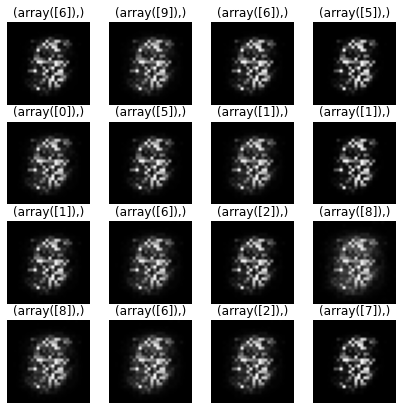

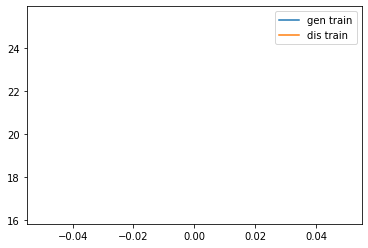

time: 7.273163318634033 
Epoch: 1, Gen[train]: 1.7747247219085693, Dis[train]: 2.2135372161865234, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 2, Gen[train]: 4.19759464263916, Dis[train]: 1.9365577697753906, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 3, Gen[train]: 3.5338659286499023, Dis[train]: 1.432327151298523, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 4, Gen[train]: 2.797419309616089, Dis[train]: 1.404077410697937, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 5, Gen[train]: 2.2329041957855225, Dis[train]: 1.7312276363372803, Gen[test]: 0.0, Dis[test]: 0.0 


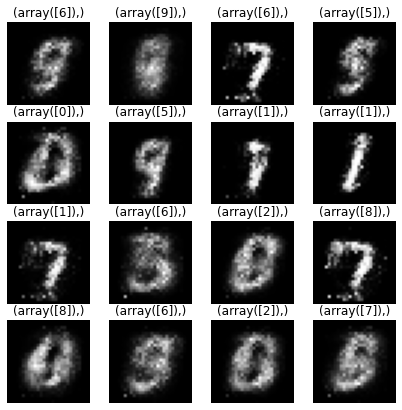

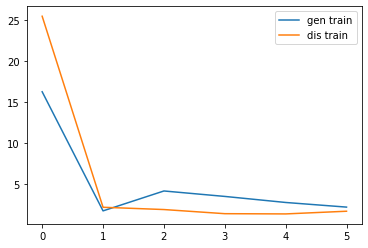

time: 16.953510761260986 
Epoch: 6, Gen[train]: 2.0456173419952393, Dis[train]: 1.7525668144226074, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 7, Gen[train]: 2.125436782836914, Dis[train]: 1.7720084190368652, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 8, Gen[train]: 2.743840456008911, Dis[train]: 2.159848928451538, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 9, Gen[train]: 2.499901056289673, Dis[train]: 2.451939582824707, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 10, Gen[train]: 2.243943214416504, Dis[train]: 1.8830609321594238, Gen[test]: 0.0, Dis[test]: 0.0 


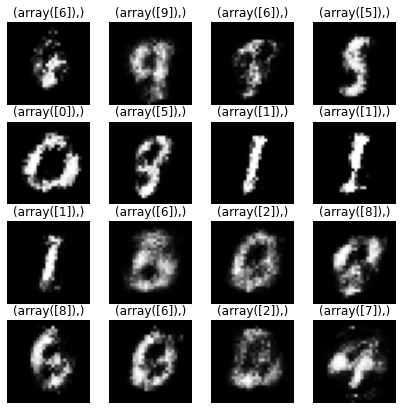

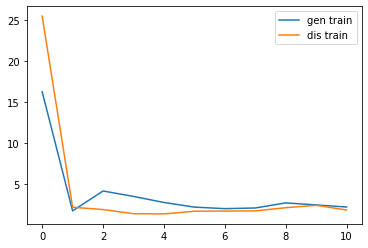

time: 26.656172513961792 
Epoch: 11, Gen[train]: 2.5991604328155518, Dis[train]: 2.3305823802948, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 12, Gen[train]: 2.3919994831085205, Dis[train]: 2.2187411785125732, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 13, Gen[train]: 2.256971836090088, Dis[train]: 2.4157445430755615, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 14, Gen[train]: 2.9663031101226807, Dis[train]: 2.5402348041534424, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 15, Gen[train]: 2.0033698081970215, Dis[train]: 2.0174107551574707, Gen[test]: 0.0, Dis[test]: 0.0 


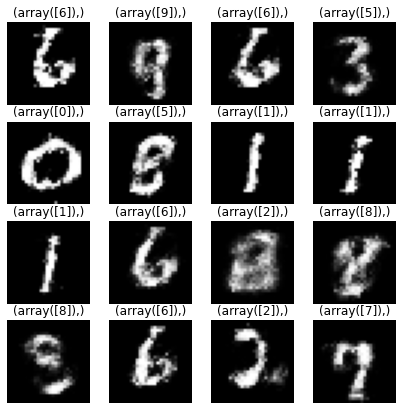

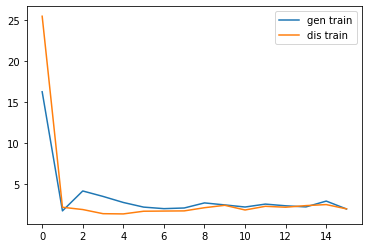

time: 36.0432026386261 
Epoch: 16, Gen[train]: 2.0854945182800293, Dis[train]: 2.328946590423584, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 17, Gen[train]: 1.7234796285629272, Dis[train]: 2.1243345737457275, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 18, Gen[train]: 1.942337989807129, Dis[train]: 2.2866222858428955, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 19, Gen[train]: 2.0682320594787598, Dis[train]: 2.5814731121063232, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 20, Gen[train]: 1.3481223583221436, Dis[train]: 1.9546760320663452, Gen[test]: 0.0, Dis[test]: 0.0 


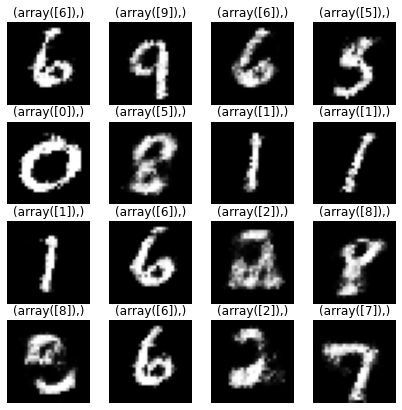

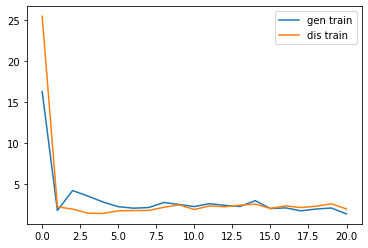

time: 45.582902669906616 
Epoch: 21, Gen[train]: 1.5856306552886963, Dis[train]: 2.1745076179504395, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 22, Gen[train]: 2.130033016204834, Dis[train]: 2.4945197105407715, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 23, Gen[train]: 2.0116472244262695, Dis[train]: 2.5077965259552, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 24, Gen[train]: 1.8102099895477295, Dis[train]: 2.3060364723205566, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 25, Gen[train]: 1.6076124906539917, Dis[train]: 2.3140194416046143, Gen[test]: 0.0, Dis[test]: 0.0 


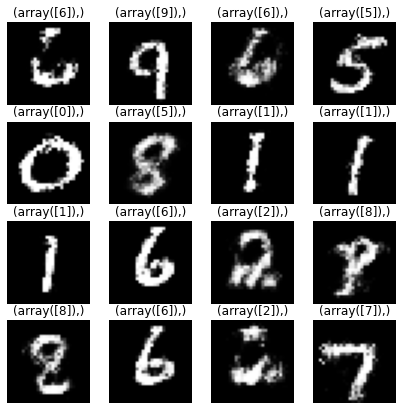

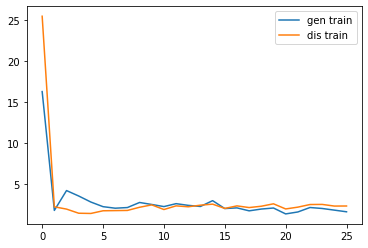

time: 55.35786271095276 
Epoch: 26, Gen[train]: 2.184072732925415, Dis[train]: 2.560980796813965, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 27, Gen[train]: 2.543121099472046, Dis[train]: 2.993403911590576, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 28, Gen[train]: 2.2791030406951904, Dis[train]: 2.8580434322357178, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 29, Gen[train]: 2.0805273056030273, Dis[train]: 2.365396499633789, Gen[test]: 0.0, Dis[test]: 0.0 
Epoch: 30, Gen[train]: 2.159085750579834, Dis[train]: 3.124244213104248, Gen[test]: 0.0, Dis[test]: 0.0 


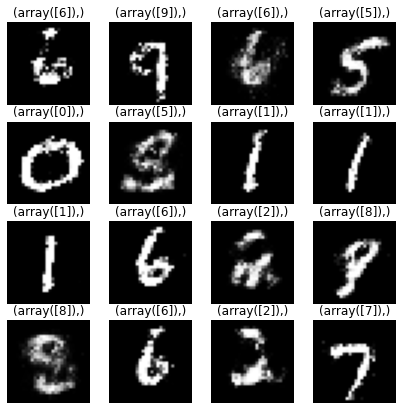

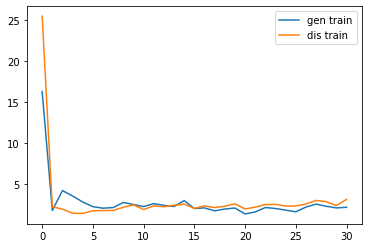

time: 64.66229820251465 
Epoch: 31, Gen[train]: 1.7844637632369995, Dis[train]: 2.8469178676605225, Gen[test]: 0.0, Dis[test]: 0.0 


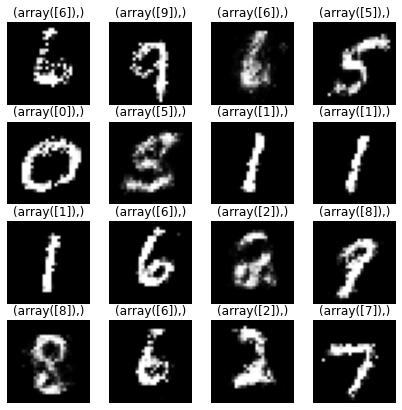

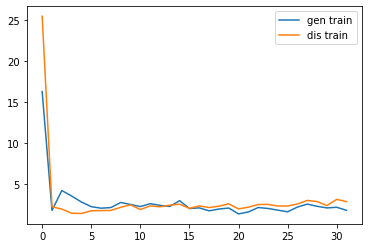

time: 67.4871711730957 
Epoch: 32, Gen[train]: 2.2427051067352295, Dis[train]: 3.045797824859619, Gen[test]: 0.0, Dis[test]: 0.0 


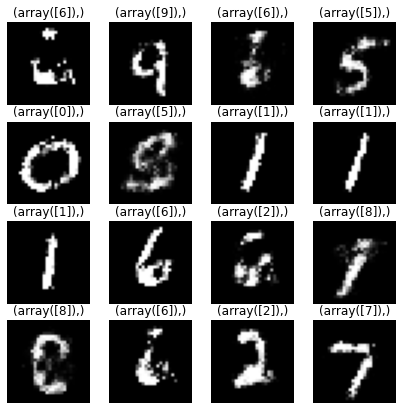

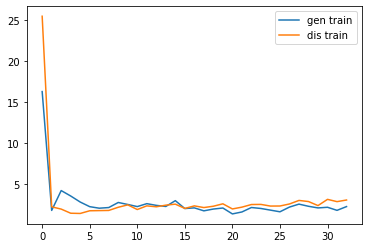

time: 70.23595261573792 
Epoch: 33, Gen[train]: 1.9641138315200806, Dis[train]: 2.379560947418213, Gen[test]: 0.0, Dis[test]: 0.0 


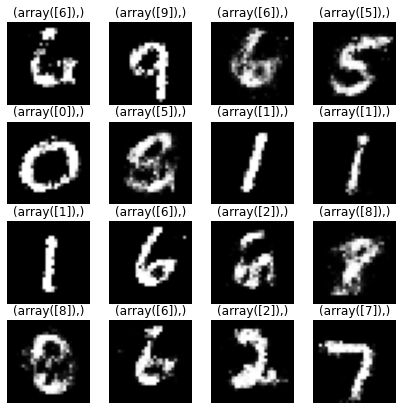

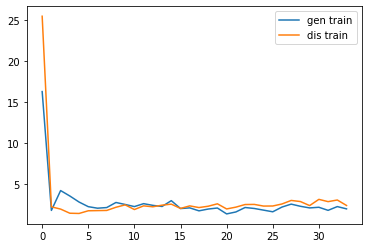

time: 73.00910592079163 
Epoch: 34, Gen[train]: 1.9304759502410889, Dis[train]: 2.663789749145508, Gen[test]: 0.0, Dis[test]: 0.0 


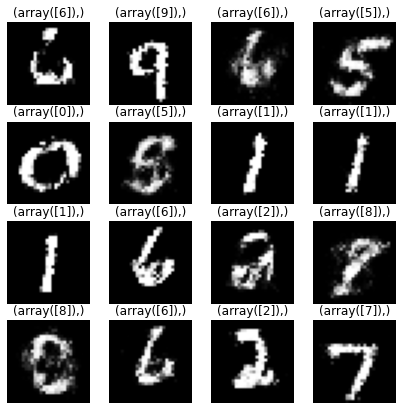

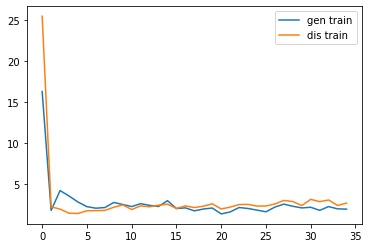

time: 76.03472876548767 
Epoch: 35, Gen[train]: 1.821052074432373, Dis[train]: 2.6092326641082764, Gen[test]: 0.0, Dis[test]: 0.0 


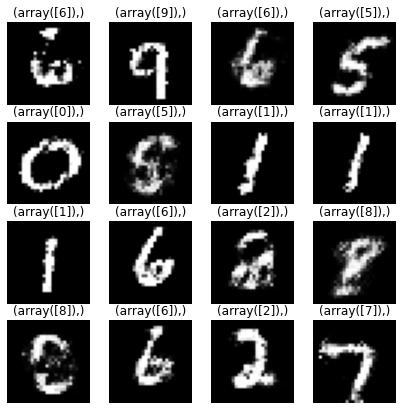

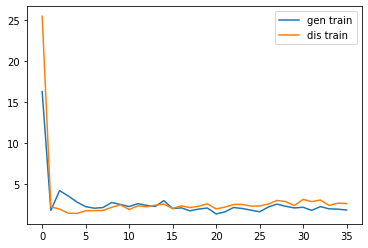

time: 78.90047430992126 
Epoch: 36, Gen[train]: 1.774169921875, Dis[train]: 2.8877933025360107, Gen[test]: 0.0, Dis[test]: 0.0 


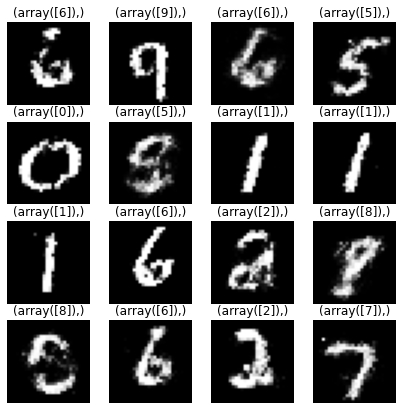

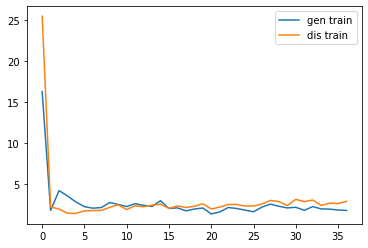

time: 81.66136908531189 
Epoch: 37, Gen[train]: 1.455475091934204, Dis[train]: 2.276322603225708, Gen[test]: 0.0, Dis[test]: 0.0 


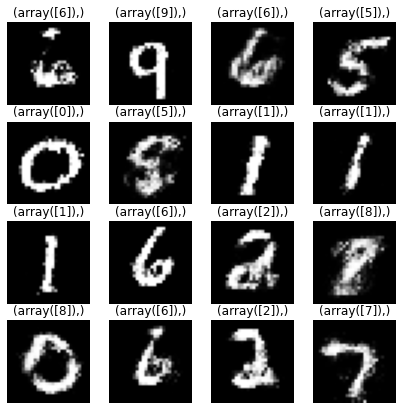

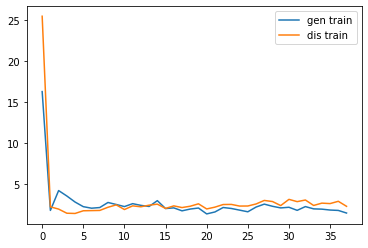

time: 84.67941951751709 
Epoch: 38, Gen[train]: 1.7291845083236694, Dis[train]: 2.651515483856201, Gen[test]: 0.0, Dis[test]: 0.0 


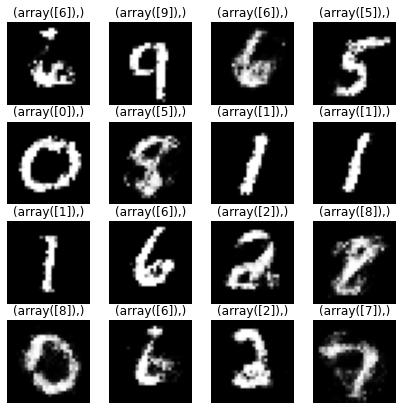

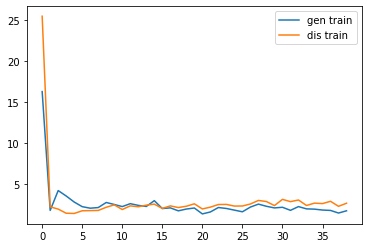

time: 87.3736925125122 
Epoch: 39, Gen[train]: 1.9947171211242676, Dis[train]: 2.817028760910034, Gen[test]: 0.0, Dis[test]: 0.0 


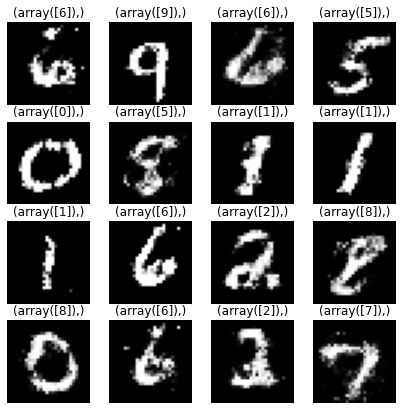

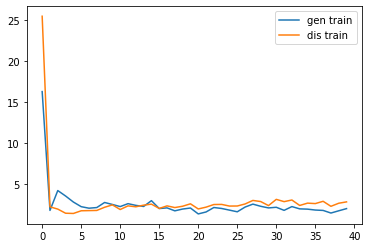

time: 90.27422094345093 
Epoch: 40, Gen[train]: 2.1410088539123535, Dis[train]: 3.175522804260254, Gen[test]: 0.0, Dis[test]: 0.0 


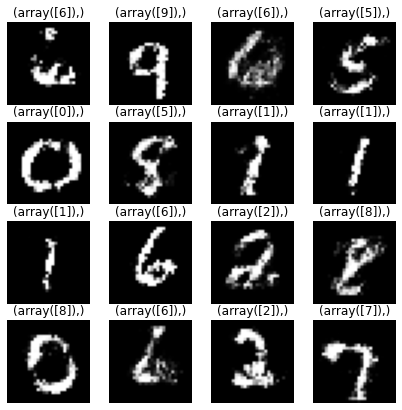

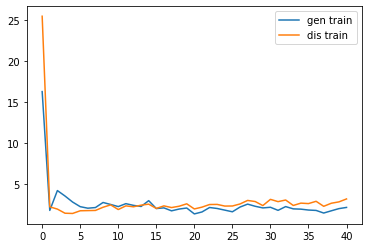

time: 92.95078182220459 
Epoch: 41, Gen[train]: 2.2469470500946045, Dis[train]: 2.6396028995513916, Gen[test]: 0.0, Dis[test]: 0.0 


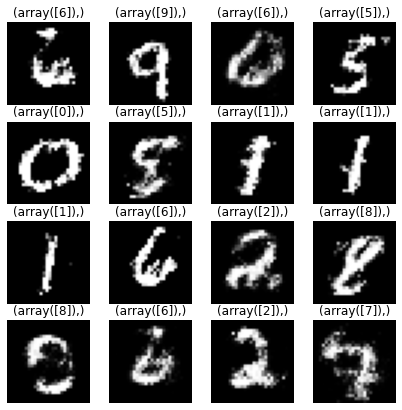

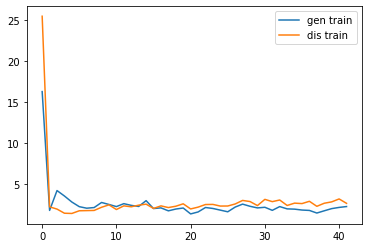

time: 95.76935505867004 
Epoch: 42, Gen[train]: 2.0655932426452637, Dis[train]: 3.2019410133361816, Gen[test]: 0.0, Dis[test]: 0.0 


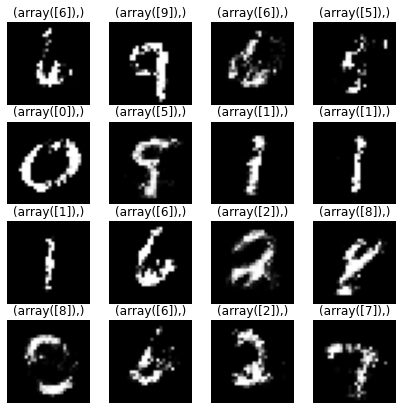

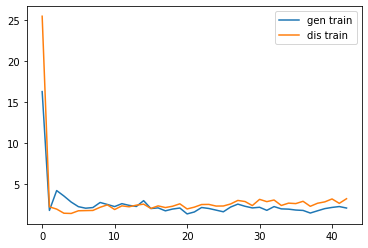

time: 98.79651761054993 
Epoch: 43, Gen[train]: 1.7581745386123657, Dis[train]: 2.4955501556396484, Gen[test]: 0.0, Dis[test]: 0.0 


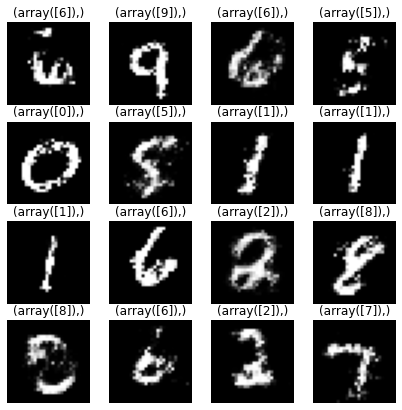

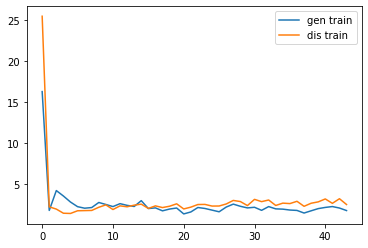

time: 101.5689685344696 
Epoch: 44, Gen[train]: 1.4878445863723755, Dis[train]: 2.4196019172668457, Gen[test]: 0.0, Dis[test]: 0.0 


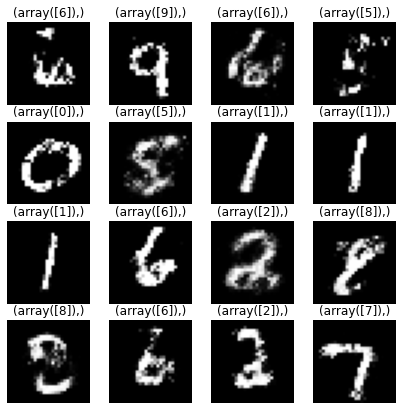

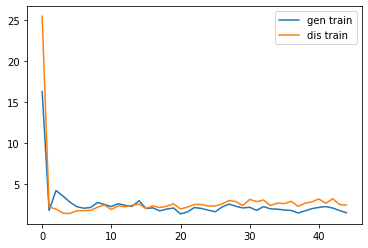

time: 104.40873956680298 
Epoch: 45, Gen[train]: 1.8768564462661743, Dis[train]: 2.7371909618377686, Gen[test]: 0.0, Dis[test]: 0.0 


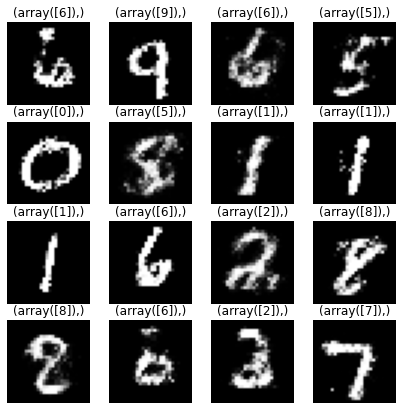

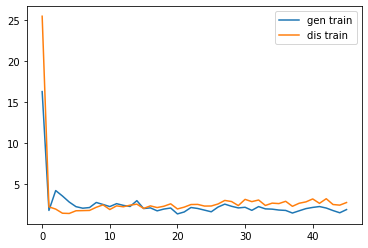

time: 107.40789842605591 
Epoch: 46, Gen[train]: 1.7642170190811157, Dis[train]: 2.950397253036499, Gen[test]: 0.0, Dis[test]: 0.0 


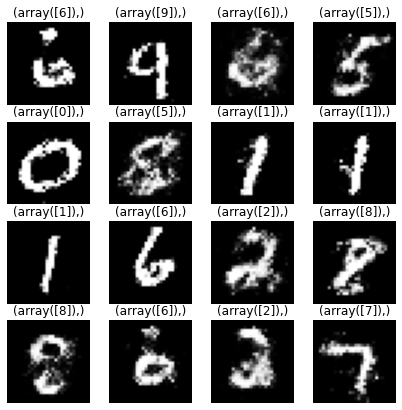

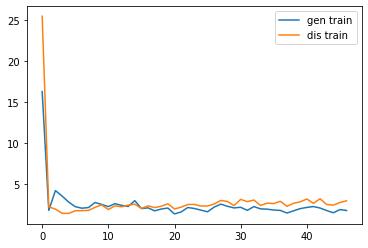

time: 110.4231026172638 
Epoch: 47, Gen[train]: 1.7627547979354858, Dis[train]: 2.9141476154327393, Gen[test]: 0.0, Dis[test]: 0.0 


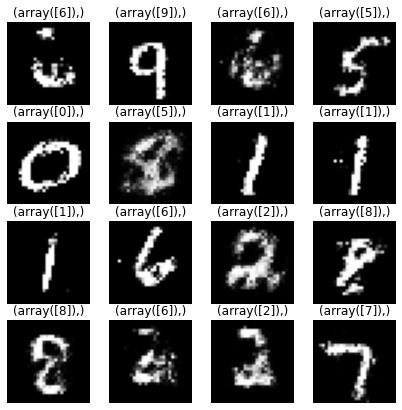

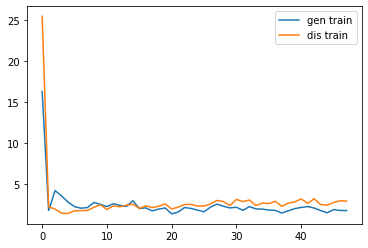

time: 113.32376408576965 
Epoch: 48, Gen[train]: 2.3921704292297363, Dis[train]: 3.100322723388672, Gen[test]: 0.0, Dis[test]: 0.0 


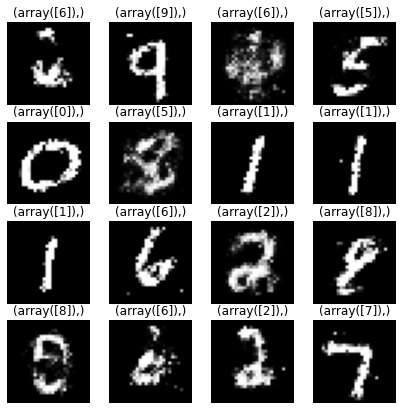

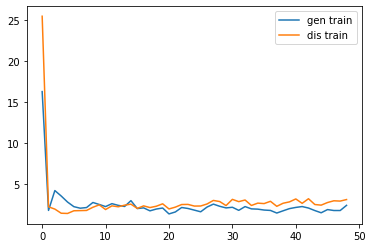

time: 116.06443476676941 
Epoch: 49, Gen[train]: 1.8302088975906372, Dis[train]: 2.6428420543670654, Gen[test]: 0.0, Dis[test]: 0.0 


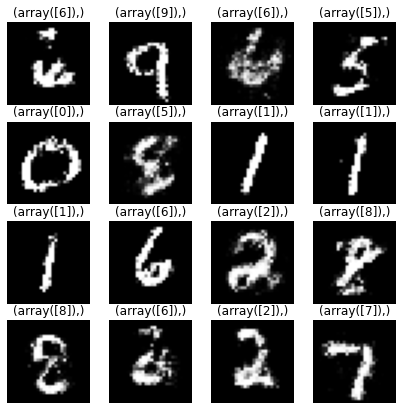

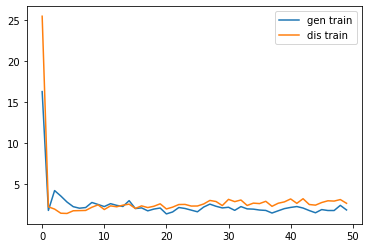

time: 118.8461525440216 


In [ ]:
import time
display_step = 5
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

arr = []
for i in range(16):
  rand_label = np.random.randint(0, 10)
  rand_label = to_categorical(rand_label, 10)
  arr.append(rand_label)

arr = np.array(arr)

train_range = 50
gen_loss_arr = []
dis_loss_arr = []
gen_tloss_arr = []
dis_tloss_arr = []
EPOCH=[]

strat_time = time.time()
for epoch in range(train_range):
  i = 0
  for x_batch in train_data:
    real = y_train[i*batch_size:(i+1)*batch_size]
    if real.shape[0] != 256:
      break;
    gen_loss, dis_loss = gen_network.train(x_batch[0], real)
    train_gen_loss(gen_loss)
    train_dis_loss(dis_loss)
    i +=1
  
  for x_batch in test_data:
    real = y_test[i*batch_size:(i+1)*batch_size]
    if real.shape[0] != 256:
      break;
    a,b, loss_gen_t, loss_dis_t = gen_network.compute_gradient(x_batch[0], real)
    test_gen_loss(loss_gen_t)
    test_dis_loss(loss_dis_t)
    i += 1
  

  gen_loss_arr.append(train_gen_loss.result())
  dis_loss_arr.append(train_dis_loss.result())
  gen_tloss_arr.append(test_gen_loss.result())
  dis_tloss_arr.append(test_dis_loss.result())
  EPOCH.append(epoch)

  print(f'Epoch: {epoch}, Gen[train]: {train_gen_loss.result()}, Dis[train]: {train_dis_loss.result()}, Gen[test]: {test_gen_loss.result()}, Dis[test]: {test_dis_loss.result()} ')

  if epoch % display_step == 0 or epoch >= 30:
    show_generated_img(gen_network, epoch + 1, seed, (arr*1.0))
    show_loss(gen_loss_arr, dis_loss_arr, gen_tloss_arr, dis_tloss_arr, EPOCH)
    print(f'time: {time.time() - strat_time} ')

  train_gen_loss.reset_states()
  train_dis_loss.reset_states()
  test_gen_loss.reset_states()
  test_dis_loss.reset_states()

In [ ]:
arr = []
for i in range(16):
    rand_label = np.random.randint(0, 10)
    rand_label = to_categorical(rand_label, 10)
    arr.append(rand_label)

a = np.array(arr)
a.all()

False